<a href="https://colab.research.google.com/github/kxk302/Covid_Clustering/blob/batch/Covid_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls '/content/gdrive/MyDrive/Colab Notebooks/Clustering/'

batch_data  batch_results  boston_data	boston_results	uk_data  uk_results


In [5]:
import ast
import bokeh.models as bmo
import numpy as np
import os
import pandas as pd

from bokeh.palettes import d3
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from matplotlib import pyplot as plt
from scipy.stats import entropy
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics

pd.set_option('display.max_columns', None)

# When calculating the distance between 2 probability densities,
# if one probability value is 0 (or very small), the cross entropy
# (distance) value would be infinity. This brakes the DBSCAN algorithm.
# Replace infinity values with a large number, say 200.00  
max_distance = 200.00

# x axis values for calculating/plotting KDE of sample AF
x_idx = np.linspace(0.00, 1.00, num=100).tolist()

def get_kde_values(row):
  return gaussian_kde(row['AF']).evaluate(x_idx).tolist()

def get_kl_div(x, y):
  return entropy(x, y)

def preprocess(file_name, sep="\t"):

  # Read the input file. Select only the needed columns.
  df = pd.read_csv(file_name, sep)[['Batch', 'AF']]
  df_in = df.copy()

  # Batch stats
  print('\n')
  print('Number of unique batches: {}'.format(df_in['Batch'].nunique()))
  print('Batch minimum: {}'.format(df_in['Batch'].min()))
  print('Batch maximum: {}'.format(df_in['Batch'].max()))

  # af stats
  print('\n')
  print('Number of unique af {}'.format(df_in['AF'].nunique()))
  print('af minimum: {}'.format(df_in['AF'].min()))
  print('af maximum: {}'.format(df_in['AF'].max()))

  # Clean up data by removing rows where af is greater than 1.0
  print('\n')
  print('Removing rows with AF greater than 1.0')
  df_af = df_in[ df_in.AF <= 1.00 ]

  # Pivot the data frame
  df_piv = pd.pivot_table(df_af, index='Batch', values='AF', aggfunc=list)
  print('df_piv.head(5)')
  print(df_piv.head(5))

  # Clean up data by removing rows where af list has only one or two element
  # KDE calculation errors out for those
  df_piv_clean = df_piv[ df_piv.AF.str.len() > 2]

  # Calculate 
  df_piv_clean['KDE_vals'] = df_piv_clean.apply(get_kde_values, axis=1)

  print('df_piv_clean.head(5)')
  print(df_piv_clean.head(5))

  return df_piv_clean

# eps: 
#   The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is the most 
#   important DBSCAN parameter to choose appropriately for your data set and distance function.
# min_samples: 
#   The number of samples n a neighborhood for a point to be considered as a core point. This includes the point itself.
# metric: 
#   The metric to use when calculating distance between instances in a feature array. 
# metric_params: 
#  Additional keyword arguments for the metric function.

def dbscan_clustering(file_name, sep='\t', eps=0.5, min_samples=5, metric='euclidean', metric_params=None, distances_file_name=None, n_jobs=1):
  df_piv_clean = preprocess(file_name, sep)

  if metric == 'precomputed':
    distances = pd.read_csv(distances_file_name, sep=sep, index_col=0)

    # Replace infinity values in distances matric with a large value
    distances.replace([np.inf], max_distance, inplace=True)

    # Run DBSCAN clustering algorithm on precomputed distance matric
    db=DBSCAN(eps=eps, min_samples=min_samples, metric=metric, metric_params=metric_params, n_jobs=n_jobs).fit(distances) 
  else:
    # Run DBSCAN clustering algorithm
    db=DBSCAN(eps=eps, min_samples=min_samples, metric=metric, metric_params=metric_params, n_jobs=n_jobs).fit(df_piv_clean.KDE_vals.tolist())

  labels = db.labels_

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  print('\n')
  print('Number of clusters: {}'.format(n_clusters_))
  print('Cluster labels: {}'.format(set(labels)))
  print('Number of noise samples: {}'.format(n_noise_))

  # Add Labels (and its string version) to the dataframe
  df_piv_clean['Labels'] = labels

  print('df_piv_clean.head(5)')
  print(df_piv_clean.head(5))

  return df_piv_clean

def get_distance_matrix(df_in):
  if df_in is None or df_in.shape[0] == 0:
    return df_in

  df = df_in.copy()

  row_count = df.shape[0]
  distances = np.zeros((row_count, row_count))

  for idx1 in range(row_count-1):
    for idx2 in range(idx1+1, row_count):
      distances[idx1][idx2] = entropy(df.iloc[idx1]['KDE_vals'], df.iloc[idx2]['KDE_vals'])
      distances[idx2][idx1] = distances[idx1][idx2]
  
  df_out = pd.DataFrame(distances)
  df_out.fillna(0.00, inplace=True)
  distances_sum = df_out.apply(np.sum)
  argmin = distances_sum.argmin()
  return df_out, df.iloc[argmin]

def plot_clusters(df_in, folder):
  if df_in is None or df_in.shape[0] == 0:
    return df_in

  df = df_in.copy()

  num_labels = df['Labels'].nunique()
  print('num_labels: {}'.format(num_labels))

  labels = df['Labels'].unique()
  print('labels: {}'.format(labels))

  fig, axs = plt.subplots(num_labels, 2, gridspec_kw={'hspace': 1.0, 'wspace': 0.5}, figsize=(15, 15))

  # Use num_labels - 1 in range, as we handle noise (-1) separately
  for label in labels:
    print('Label processed: {}'.format(label))

    # idx used in plot axes
    idx = 0
    if label != -1:
      idx = label
    else:
      idx = num_labels - 1

    df_lbl = df[ df.Labels == label ]
    
    distances, cluster_center = get_distance_matrix(df_lbl)
    print('Cluster center for label ' + str(label))
    print(cluster_center)
    
    # Histogram
    xh = cluster_center[0]
    axs[idx][0].hist(xh, density=True)
    axs[idx][0].title.set_text('Cluster ' + str(label) + ' (size ' + str(df_lbl.shape[0]) + ') AF histogram')

    # KDE 
    xk = x_idx
    yk = cluster_center[1]
    axs[idx][1].plot(xk, yk)
    axs[idx][1].title.set_text('Cluster ' + str(label) + ' (size ' + str(df_lbl.shape[0]) + ') AF density estimate')
    
  plt.savefig(folder + '/dbscan_' + str(num_labels) + '.png')
  # plt.show()

def get_cluster_batches(df_in, sep, folder):
  if df_in is None or df_in.shape[0] == 0:
    return df_in
 
  df = df_in.copy()

  labels = df['Labels'].unique()
  print('labels: {}'.format(labels))

  for label in labels:
    df_lbl = df[ df.Labels == label ]
    df_lbl.to_csv(folder + '/cluster_' + str(label) + '.tsv', sep='\t')

In [6]:
# Run DBSCAN clustering algorithm on batch dataset
#
# Using 0.0075 for esp (epsilon) to yield ? clusters
# Using default value of 5 for min_samples 
# Using get_kl_div method for metric. get_kl_div() calculates Kullback-Leibler divergence, 
#     which measures the distance between 2 proabaility distributions
# Using None for metric_params, as the metric has no parameters
#

# 1. Cleaned the data (Removed rows with AF > 1.0)
# 2. Pivoted the data so all AFs of a batch are listed on one line
# 3. Calculated Kernel Density Estimates (KDE) of AFs of each batch
#      Evaluated them on 100 data points in range of 0.0 to 1.0
# 4. Ran DBSCAN clustering algorithm
#      epsilon: 0.0075
#      Used Kullback-Liebler (KL) div. to calculate distance between density estimate
#      metric: 'precomputed'. See note below
# 5. DBSCAN produced ? clusters
#      Data points not assigned to any cluster marked as Noise (or cluster -1)
# 6. For each cluster, found a representative batch
#      Calculated KL div. between every pair of batches in a cluster
#      Selected batch with the smallest sum of distances


# Calculated the distance matrix. We run the code below just once, and save the 
# distance matrix to file. We pass the distance matrix file to DBSCAN. that way 
# if we modify DBSCAN parameters (say, eps or num_samples), we avoid calculating 
# the distance matrix repeatedly. Must set metric to 'precomputed'

#df = preprocess('./uk_data/batch.tsv', sep='\t')
#distances, _ = get_distance_matrix(df)
#distances.to_csv('./uk_data/distances_batch.tsv', sep='\t')

def dbscan_clustering_wrapper(eps=0.0085, 
                              min_samples=7,
                              path = '/content/gdrive/MyDrive/Colab Notebooks/Clustering/',
                              data_file='batch.tsv',
                              sep='\t',
                              data_folder = 'batch_data',
                              results_folder = 'batch_results',
                              metric='precomputed'):
  folder = str(min_samples) + '_' + str(eps)
  print('folder: {}'.format(folder))
  full_path = os.path.join(path, results_folder, folder)
  print('full_path: {}'.format(full_path))
  os.mkdir(full_path)

  full_data_folder = os.path.join(path, data_folder)
  full_results_folder = os.path.join(path, results_folder, folder)

  df = dbscan_clustering(file_name=full_data_folder+'/'+data_file,
                         sep=sep, 
                         eps=eps, 
                         min_samples=min_samples, 
                         #metric=get_kl_div,
                         metric=metric,
                         metric_params=None,
                         distances_file_name=full_data_folder+'/distances_'+data_file)

  df.to_csv(full_results_folder + '/all_clusters_eps_' + str(eps) + '_min_samples_' + str(min_samples) + '.tsv', sep=sep)
  plot_clusters(df, folder=full_results_folder)
  get_cluster_batches(df_in=df, sep=sep, folder=full_results_folder)

In [ ]:
# Run DBSCAN algorithm on 'data_file' in 'data_folder' and save the results to 'results_folder'. 
dbscan_clustering_wrapper(eps=0.0250, 
                          min_samples=3,
                          path = '/content/gdrive/MyDrive/Colab Notebooks/Clustering/',
                          data_file='batch.tsv',
                          sep='\t',
                          data_folder = 'batch_data',
                          results_folder = 'batch_results',
                          metric='precomputed')

                Batch      Sample
0    0ce66d803a055fef  ERR5549561
42   0ce66d803a055fef  ERR5549562
83   0ce66d803a055fef  ERR5549563
120  0ce66d803a055fef  ERR5549564
163  0ce66d803a055fef  ERR5549565
210  0ce66d803a055fef  ERR5549566
248  0ce66d803a055fef  ERR5549567
285  0ce66d803a055fef  ERR5549568
323  0ce66d803a055fef  ERR5549569
367  0ce66d803a055fef  ERR5643745
406  87f9807bf2e0660b  ERR5549545
444  87f9807bf2e0660b  ERR5549546
474  87f9807bf2e0660b  ERR5549547
510  87f9807bf2e0660b  ERR5549548
546  87f9807bf2e0660b  ERR5549549
586  87f9807bf2e0660b  ERR5549550
596  87f9807bf2e0660b  ERR5549551
637  87f9807bf2e0660b  ERR5549552
677  87f9807bf2e0660b  ERR5549553
714  87f9807bf2e0660b  ERR5549554
<class 'pandas.core.frame.DataFrame'>
                  Sample
Batch                   
00ac59cfc7cd16df      18
010b73d60883c859     354
010db33f449760f6      94
01260d0ae85deee5      90
01352766709fd0e9      15
...                  ...
ffb48b3acdcc5583     351
ffc5d29b85a9e89b       

(array([385., 126.,  73.,  35.,  30.,  60., 124., 438., 178.,   2.]),
 array([  1. ,  44.9,  88.8, 132.7, 176.6, 220.5, 264.4, 308.3, 352.2,
        396.1, 440. ]),
 <a list of 10 Patch objects>)

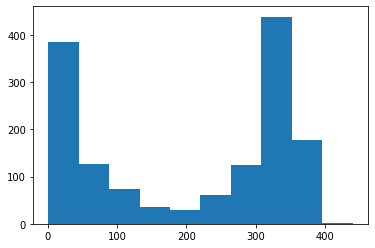

In [27]:
# Histogram for number of samples in a batch

# Read the input file. Select only the needed columns.
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Clustering/batch_data/batch.tsv', sep='\t')[['Batch','Sample']]
df_no_dup = df.drop_duplicates()
print(df_no_dup.head(20))
count = df_no_dup.groupby('Batch').count()
print(type(count))
print(count)
print(count['Sample'].values)
plt.hist(count['Sample'].values)
